In [1]:
#!pip install catboost

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", 200)

from catboost import CatBoostRegressor

from sklearn.model_selection import train_test_split
#from sklearn.model_selection import RandomizedSearchCV
#from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import RepeatedKFold, cross_val_score, cross_validate

In [3]:
df = pd.read_csv('housing_clean.csv', index_col=0)
df.shape

(2374, 98)

In [4]:
df.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
Index: 2374 entries, 224 to 648
Data columns (total 98 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   PID                   2374 non-null   int64  
 1   GrLivArea             2374 non-null   int64  
 2   SalePrice             2374 non-null   int64  
 3   MSSubClass            2374 non-null   int64  
 4   MSZoning              2374 non-null   object 
 5   LotFrontage           2374 non-null   float64
 6   LotArea               2374 non-null   int64  
 7   Street                2374 non-null   object 
 8   Alley                 118 non-null    object 
 9   LotShape              2374 non-null   object 
 10  LandContour           2374 non-null   object 
 11  Utilities             2374 non-null   object 
 12  LotConfig             2374 non-null   object 
 13  LandSlope             2374 non-null   object 
 14  Neighborhood          2374 non-null   object 
 15  BldgType              237

### Remove original columns that have been ordinalized

In [5]:
df = df.drop(columns=[col for col in df.columns if col.endswith('_todrop')])

### Handle nominal features
- For CatBoost, we don't need to dummify nominal features
- We do need to covert all nominal feature columns into string data type
- Better to do this before train / test split

In [6]:
categ_nom = ['MSSubClass','BldgType','HouseStyle','SaleType','SaleCondition','MiscFeature',
             'Fence','GarageType','RoofStyle','RoofMatl','exterior_covering','MasVnrType',
             'MSZoning','Street','LotShape','LandContour','LotConfig','LandSlope','Neighborhood',
             'Alley','condition','Foundation','Utilities','Heating',
             'CentralAir','MoSold','Electrical','QrtSold','YrSold']

In [7]:
# check data type for each nominal feature
print(df[categ_nom].dtypes)

MSSubClass            int64
BldgType             object
HouseStyle           object
SaleType             object
SaleCondition        object
MiscFeature          object
Fence                object
GarageType           object
RoofStyle            object
RoofMatl             object
exterior_covering    object
MasVnrType           object
MSZoning             object
Street               object
LotShape             object
LandContour          object
LotConfig            object
LandSlope            object
Neighborhood         object
Alley                object
condition            object
Foundation           object
Utilities            object
Heating              object
CentralAir           object
MoSold                int64
Electrical           object
QrtSold              object
YrSold                int64
dtype: object


In [8]:
# turn all nominal features into string type so it can be passed in cat_features argument later
df[categ_nom] = df[categ_nom].astype(str)

In [9]:
print(df[categ_nom].dtypes)

MSSubClass           object
BldgType             object
HouseStyle           object
SaleType             object
SaleCondition        object
MiscFeature          object
Fence                object
GarageType           object
RoofStyle            object
RoofMatl             object
exterior_covering    object
MasVnrType           object
MSZoning             object
Street               object
LotShape             object
LandContour          object
LotConfig            object
LandSlope            object
Neighborhood         object
Alley                object
condition            object
Foundation           object
Utilities            object
Heating              object
CentralAir           object
MoSold               object
Electrical           object
QrtSold              object
YrSold               object
dtype: object


### Perform Train / Test Split

In [10]:
X = df.drop(['SalePrice', 'PID'], axis = 1)
y = df['SalePrice']

In [11]:
# Split the data into train and test based on the year the house was sold
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

X_train = df.loc[df['YrSold'].astype(int).between(2006, 2009)].drop(['SalePrice', 'PID'], axis = 1)
X_test = df.loc[df['YrSold'].astype(int) == 2010].drop(['SalePrice', 'PID'], axis = 1)

y_train = df.loc[df['YrSold'].astype(int).between(2006, 2009)]['SalePrice']
y_test = df.loc[df['YrSold'].astype(int) == 2010]['SalePrice']

### Setting up a baseline model before any tuning

* **Set a fair baseline:** Train a plain (untuned) model to get a reference R² you can compare against after tuning.
* **Reduce split luck:** Repeat cross validation multiple times for the training dataset and **average** the R² so your baseline isn’t driven by a single “easy” or “hard” split.
* **Isolate variability:** Fix the model’s `random_state` so differences come from the **data splits**, not extra model randomness.
* **Make comparisons honest:** Report mean ± std of train/test R² from these repeats; tuning “wins” only if it beats this baseline by more than the noise.

In [13]:
model_baseline = CatBoostRegressor(
    cat_features=categ_nom,
    verbose=0,  # Suppress training output
    random_state=42)

In [14]:
model_baseline.fit(X_train, y_train)

In [15]:
# evaluate untuned / baseline model
y_train_pred = model_baseline.predict(X_train)
y_test_pred = model_baseline.predict(X_test)

# R2
r2_baseline_train = model_baseline.score(X_train, y_train)
r2_baseline_test = model_baseline.score(X_test, y_test)

print(f"Train R square: {r2_baseline_train:.4f}")
print(f"Test R square: {r2_baseline_test:.4f}")

# root mean squared error, lower is better
# sensitive to outliers
# tells you the average size of the error in prediction — in dollar terms
rmse_baseline_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_baseline_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f"Train Root Mean Squared Error: {rmse_baseline_train:.2f}")
print(f"Test Root Mean Squared Error: {rmse_baseline_test:.2f}")

Train R square: 0.9874
Test R square: 0.9319
Train Root Mean Squared Error: 8480.36
Test Root Mean Squared Error: 19397.18


In [16]:
# Implementing Repeated K-Fold Cross-Validation (before tuning any hyperparameters)

n_splits = 5
n_repeats = 3
rkf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=42)

# Initialize baseline model
model = CatBoostRegressor(
    cat_features=categ_nom,
    verbose=0,  # Suppress training output
    random_state=42)

# Lists to store the scores and RMSE values
scores = []
rmse_values = []

# Perform the cross-validation on the TRAINING data
for train_index, val_index in rkf.split(X_train):
    # Split the training data into internal training and validation sets
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    # Train the model on the training fold
    model.fit(X_train_fold, y_train_fold)

    # Evaluate the model on the validation fold
    score = model.score(X_val_fold, y_val_fold)
    scores.append(score)
    
    # Calculate RMSE manually
    y_pred_val = model.predict(X_val_fold)
    rmse = np.sqrt(mean_squared_error(y_val_fold, y_pred_val))
    rmse_values.append(rmse)

# Calculate the average score
average_score = np.mean(scores)
average_rmse = np.mean(rmse_values)
std_rmse = np.std(rmse_values)

print(f"Average baseline R-squared score: {average_score:.4f}")
print(f"Average baseline RMSE: ${average_rmse:.2f}")
print(f"Standard deviation of RMSE: ${std_rmse:.2f}")

Average baseline R-squared score: 0.9300
Average baseline RMSE: $19799.04
Standard deviation of RMSE: $3354.87


## Hyperparameter Tuning

### First, trying RandomizedSearchCV to find the best model
- The best R squared found is 86%, not ideal

In [17]:
# param_grid = {
#     "iterations": [500, 800, 1000],
#     "depth": [4, 6, 8],
#     "learning_rate": [0.01, 0.05, 0.1],
#     "l2_leaf_reg": [1, 3, 5],
#     "bagging_temperature": [0.5, 1, 2],
#     "border_count": [32, 64, 128]
# }

In [18]:
# random_search = RandomizedSearchCV(
#     estimator=model,
#     param_distributions=param_grid,
#     n_iter=20,                # number of random combos to try
#     #scoring='neg_root_mean_squared_error',
#     scoring='r2',
#     cv=5,
#     random_state=42,
#     n_jobs=-1,
#     verbose=0
# )

# random_search.fit(X_train, y_train)

# print("Best CV R-squared:", random_search.best_score_)
# print("Best Parameters:", random_search.best_params_)

### Secondly, experimenting with Optuna

In [19]:
#!pip install optuna

In [20]:
import optuna
from optuna.samplers import TPESampler

In [21]:
# It's a good practice to set up logging to see Optuna's progress
optuna.logging.set_verbosity(optuna.logging.INFO)

#X_tra, X_val, y_tra, y_val
#def objective(trial, X_tra, X_val, y_tra, y_val):
def objective(trial):
    """
    This function defines the search space for Optuna. It suggests hyperparameters,
    trains the model on the training set, evaluates it on the validation set, and returns
    a single value to be optimized (R-squared score).

    Args:
        trial (optuna.trial.Trial): The trial object that suggests hyperparameters.

    Returns:
        float: The R-squared score on the validation set.
    """
    # Define the search space for the hyperparameters using trial.suggest_...
    param = {
        # 'iterations': The number of boosting iterations (trees).
        # if removed, it simplifies the problem 
        'iterations': trial.suggest_int('iterations', 500, 1500, step=100),
        
        # 'depth': The depth of the trees.
        'depth': trial.suggest_int('depth', 4, 10),
        
        # 'min_data_in_leaf': stop splitting a node if the resulting child nodes would have fewer than this 
        # minimum number of data points
        'min_data_in_leaf': trial.suggest_int("min_data_in_leaf", 2, 20),
        
        # 'learning_rate': The step size shrinkage.
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        
        # 'l2_leaf_reg': The L2 regularization coefficient.
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        
        # 'one_hot_max_size': If a categorical feature has a number of unique values that is less than or equal to the
        # this threshold, CatBoost wil perfomr on-hot encoding. If the number of unique values is greater,
        # CatBoost will use its native, more advanced methods for processing the feature
        'one_hot_max_size': trial.suggest_int("one_hot_max_size", 2, 20), 
        
        # 'bagging_temperature': The bagging temperature for feature subsampling.
        # doesn't seem to drive hyperparameter optimization after first try
        #'bagging_temperature': trial.suggest_float('bagging_temperature', 0.5, 5),
        
        # 'border_count': specifies the maximum number of bins that will be created for 
        # each numerical feature. CatBoost doesn't consider every single unique value of a feature as a potential
        # split point, instead, it groups the feature values into a limited number of 'bins' and only considers the
        # boundaries of these bins as potential split points
        'border_count': trial.suggest_int('border_count', 32, 255),
        
        # 'random_seed': Use a fixed seed for reproducibility across trials.
        'random_seed': 42,
        'verbose': 0
    }

    # Initialize the CatBoost Regressor with the parameters suggested by the trial
    model = CatBoostRegressor(**param, cat_features=categ_nom)

    
    # Implementing Repeated K-Fold Cross-Validation (before tuning any hyperparameters)
    n_splits = 5
    n_repeats = 3
    rkf = RepeatedKFold(n_splits=n_splits,n_repeats=n_repeats,random_state=42) 
    
    r2_scores = []
    
    for train_index, val_index in rkf.split(X_train):
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
    
    
    
    # Train the model on the training data.
    # We use the test set as the evaluation set to allow for early stopping,
    # which can prevent overfitting and save time.
    model.fit(X_train_fold, y_train_fold, eval_set=[(X_val_fold, y_val_fold)], early_stopping_rounds=50, verbose=0)

    # Make predictions on the validation data
    y_pred = model.predict(X_val_fold)
    
    # Calculate the R-squared score on the validation set
    r2 = r2_score(y_val_fold, y_pred)
    r2_scores.append(r2)

    # Optuna needs a single value to optimize, so we return the R-squared score
    return np.mean(r2_scores)

In [22]:
# --- Create the Optuna study and run the optimization ---
# We want to maximize the R-squared score, so we set direction='maximize'
# We explicitly use TPESampler as requested.
study = optuna.create_study(
    direction='maximize',
    sampler=TPESampler(seed=42)
)

print("Starting Optuna optimization for hyperparameter tuning...")
# Run the optimization for a specified number of trials.
# We use a lambda function to pass the data to the objective function.
#study.optimize(lambda trial: objective(trial, X_train, X_test, y_train, y_test), n_trials=100, show_progress_bar=True)
study.optimize(objective, n_trials=50, show_progress_bar=True)

# --- Print the results ---
print("-" * 30)
print("Optuna optimization completed.")
print(f"Number of finished trials: {len(study.trials)}")
print(f"Best R-squared score found: {study.best_value:.4f}")
print("\nBest parameters found:")
for param, value in study.best_params.items():
    print(f"  {param}: {value}")

[I 2025-09-12 15:31:12,544] A new study created in memory with name: no-name-a8b7b754-b07c-425d-aa22-f86ba2e2f61c


Starting Optuna optimization for hyperparameter tuning...


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-09-12 15:31:16,928] Trial 0 finished with value: 0.9210848379492279 and parameters: {'iterations': 900, 'depth': 10, 'min_data_in_leaf': 15, 'learning_rate': 0.060099747183803134, 'l2_leaf_reg': 2.4041677639819286, 'one_hot_max_size': 4, 'border_count': 45}. Best is trial 0 with value: 0.9210848379492279.
[I 2025-09-12 15:31:20,385] Trial 1 finished with value: 0.9258160142770311 and parameters: {'iterations': 1400, 'depth': 8, 'min_data_in_leaf': 15, 'learning_rate': 0.010636066512540286, 'l2_leaf_reg': 9.72918866945795, 'one_hot_max_size': 17, 'border_count': 79}. Best is trial 1 with value: 0.9258160142770311.
[I 2025-09-12 15:31:21,408] Trial 2 finished with value: 0.9414968227033594 and parameters: {'iterations': 700, 'depth': 5, 'min_data_in_leaf': 7, 'learning_rate': 0.048164145309070844, 'l2_leaf_reg': 4.887505167779041, 'one_hot_max_size': 7, 'border_count': 169}. Best is trial 2 with value: 0.9414968227033594.
[I 2025-09-12 15:31:22,907] Trial 3 finished with value: 0

[I 2025-09-12 15:32:05,287] Trial 26 finished with value: 0.9383450496686797 and parameters: {'iterations': 1200, 'depth': 4, 'min_data_in_leaf': 11, 'learning_rate': 0.05366962342298163, 'l2_leaf_reg': 2.1895144944132294, 'one_hot_max_size': 11, 'border_count': 131}. Best is trial 17 with value: 0.9451456603260397.
[I 2025-09-12 15:32:06,189] Trial 27 finished with value: 0.9395586041426583 and parameters: {'iterations': 1500, 'depth': 6, 'min_data_in_leaf': 8, 'learning_rate': 0.0968444452754903, 'l2_leaf_reg': 3.428827233009023, 'one_hot_max_size': 8, 'border_count': 186}. Best is trial 17 with value: 0.9451456603260397.
[I 2025-09-12 15:32:07,138] Trial 28 finished with value: 0.9399149225788516 and parameters: {'iterations': 1300, 'depth': 5, 'min_data_in_leaf': 6, 'learning_rate': 0.040807893091473514, 'l2_leaf_reg': 6.0948823015870515, 'one_hot_max_size': 14, 'border_count': 227}. Best is trial 17 with value: 0.9451456603260397.
[I 2025-09-12 15:32:11,391] Trial 29 finished with

In [23]:
study.best_params

{'iterations': 1400,
 'depth': 6,
 'min_data_in_leaf': 4,
 'learning_rate': 0.10871084492969763,
 'l2_leaf_reg': 6.242597940196301,
 'one_hot_max_size': 15,
 'border_count': 175}

### Hyperparameter Importances Plot
- This plot shows you which hyperparameters were most influential in determining the model's performance during the optimization process. The importance is calculated by analyzing how much each parameter's value impacted the final R-squared score.

- Essentially, if a hyperparameter like learning_rate or depth has a high importance score, it means that changes to its value led to significant changes in the model's performance. Conversely, a parameter with a low importance score means that varying its value didn't have much effect on the final outcome.

- This plot is incredibly useful for refining your next optimization. For instance, if you see that a certain hyperparameter has very low importance, you might be able to fix its value or remove it from the search space in a future run to make the optimization faster and more efficient.

In [24]:
optuna.visualization.plot_param_importances(study)

### Optimization History Plot
- This plot helps you understand if your optimization is making good progress or if it has reached its full potential.

- Trial-by-Trial Performance: Each dot on the plot represents a single trial (one set of hyperparameters) and its corresponding objective value (the R-squared score in your case). This shows you how the model performed with different parameter combinations.

- Progress Over Time: The x-axis represents the trial number. As you move from left to right, you can see how the performance of the trials changes over the course of the optimization.

- Convergence: The most important part of this plot is the "best value so far" line. This line shows the highest R-squared score found up to each trial. If this line starts to flatten out and doesn't improve much over the last few trials, it's a strong indicator that the optimization has converged. This can tell you that running more trials might not be necessary to find a better solution.

In [25]:
optuna.visualization.plot_optimization_history(study)

### Run Repeated K-fold cross-validation on the entire dataset with the best hyperparameters
- By running K-fold cross-validation on the entire dataset with the best hyperparameters, you are training and evaluating the model on multiple different data splits. The average score across all folds gives you a much more robust and less optimistic R-squared value that better reflects the model's true generalization performance. It essentially removes the bias of a single train/test split.

In [26]:
# --- Cross-Validation with Final Model ---
print("\n" + "="*50)
print("Performing K-fold Cross-Validation with the Final Model...")
print("="*50)

# Re-instantiate the final model with best parameters
final_model = CatBoostRegressor(
    **study.best_params, 
    cat_features=categ_nom,
    verbose=0,
    random_seed=42
)

# Implementing Repeated K-Fold Cross-Validation (before tuning any hyperparameters)

n_splits = 5
n_repeats = 3
rkf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=42)

scoring = {'r2': 'r2',
           'neg_RMSE': 'neg_root_mean_squared_error'
          }


# Perform cross-validation and get the R-squared scores
# We use the full dataset (X, y) for cross-validation
cv_scores = cross_validate(final_model, X, y, cv=rkf, scoring=scoring, n_jobs=-1)

# Print the results for each metric
print("\nCross-Validation Results:")
for metric_name, score_array in cv_scores.items():
    if metric_name.startswith('test_'):
        display_name = metric_name.replace('test_', '')
        print(f"  Validation {display_name} scores: {np.round(score_array, 4)}")
        print(f"  Mean Validation {display_name} score: {np.mean(score_array):.4f}")
        print(f"  Standard deviation of {display_name} score: {np.std(score_array):.4f}")
        print("-" * 30)


Performing K-fold Cross-Validation with the Final Model...

Cross-Validation Results:
  Validation r2 scores: [0.9568 0.9375 0.9395 0.9592 0.8656 0.9454 0.9362 0.886  0.9295 0.9445
 0.9346 0.9532 0.9307 0.9433 0.8885]
  Mean Validation r2 score: 0.9300
  Standard deviation of r2 score: 0.0268
------------------------------
  Validation neg_RMSE scores: [-16978.7055 -20318.074  -16899.411  -15274.2283 -25013.8578 -18886.1692
 -18447.0792 -25292.1677 -20302.9961 -16747.591  -19888.7047 -14535.365
 -21124.8226 -18662.1883 -24077.1633]
  Mean Validation neg_RMSE score: -19496.5683
  Standard deviation of neg_RMSE score: 3208.2718
------------------------------


In [27]:
cv_scores.items()

dict_items([('fit_time', array([9.12523508, 9.5422771 , 8.56845617, 9.52625394, 9.52375031,
       9.14784384, 9.38443685, 9.32890177, 8.82065082, 7.98084307,
       8.52276993, 8.27473879, 8.43855906, 8.21502495, 7.80835986])), ('score_time', array([0.02138376, 0.01989698, 0.01223588, 0.01242185, 0.04436684,
       0.00993204, 0.02315593, 0.01186824, 0.01364422, 0.01045775,
       0.00742006, 0.0072279 , 0.00346279, 0.00529885, 0.01150894])), ('test_r2', array([0.95677471, 0.93748721, 0.93948332, 0.95918864, 0.8655777 ,
       0.94538698, 0.93624307, 0.88595537, 0.92949107, 0.94450572,
       0.93458556, 0.95315456, 0.93067477, 0.94332156, 0.88850563])), ('test_neg_RMSE', array([-16978.70547584, -20318.07401799, -16899.41104833, -15274.22828701,
       -25013.85781566, -18886.16923091, -18447.07918619, -25292.16770618,
       -20302.9960535 , -16747.59102578, -19888.70474507, -14535.36498226,
       -21124.82259629, -18662.18830218, -24077.16328019]))])

In [28]:
pd.DataFrame(cv_scores).describe()

fit_time  score_time    test_r2  test_neg_RMSE
count  15.000000   15.000000  15.000000      15.000000
mean    8.813873    0.014285   0.930022  -19496.568250
std     0.596503    0.010055   0.027708    3320.876819
min     7.808360    0.003463   0.865578  -25292.167706
25%     8.356649    0.008676   0.930083  -20721.448307
50%     8.820651    0.011868   0.937487  -18886.169231
75%     9.356669    0.016771   0.944946  -16939.058262
max     9.542277    0.044367   0.959189  -14535.364982

In [29]:
# Get the mean R-squared from the cross-validation results
cv_r2_mean = np.mean(cv_scores['test_r2'])

### Evaluate on Test Set

In [30]:
# Retrain the model using the best hyperparameters found by Optuna
final_model = CatBoostRegressor(
    **study.best_params, 
    cat_features=categ_nom,
    verbose=0,
    random_seed=42
)

final_model.fit(X_train, y_train)

In [31]:
# root mean squared error, lower is better
# sensitive to outliers
# tells you the average size of the error in prediction — in dollar terms

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)

final_rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
final_rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f"Final RMSE on the train set: ${final_rmse_train:.4f}")
print(f"Final RMSE on the test set: ${final_rmse_test:.4f}")

# R2
r2_5kf_train = final_model.score(X_train, y_train)
r2_5kf_test = final_model.score(X_test, y_test)

print(f"Train R square: {r2_5kf_train:.4f}")
print(f"Test R square: {r2_5kf_test:.4f}") 

Final RMSE on the train set: $3234.9560
Final RMSE on the test set: $21560.7693
Train R square: 0.9982
Test R square: 0.9159


### Extract Feature Importance

In [32]:
feature_importance_final = pd.DataFrame({"feature": X.columns, 
                                            "importance_cb_5fk":final_model.feature_importances_})

In [33]:
feature_importance_final.sort_values("importance_cb_5fk", ascending = False, inplace=True);
feature_importance_final.head(10)

feature  importance_cb_5fk
15          OverallQual          27.236637
0             GrLivArea          18.954693
4               LotArea           5.797290
27          TotalBsmtSF           5.220698
12         Neighborhood           3.637766
24           BsmtFinSF1           3.276012
31             1stFlrSF           3.079455
68     BsmtQual_ordinal           2.586884
64  FireplaceQu_ordinal           2.292936
17            YearBuilt           2.156768

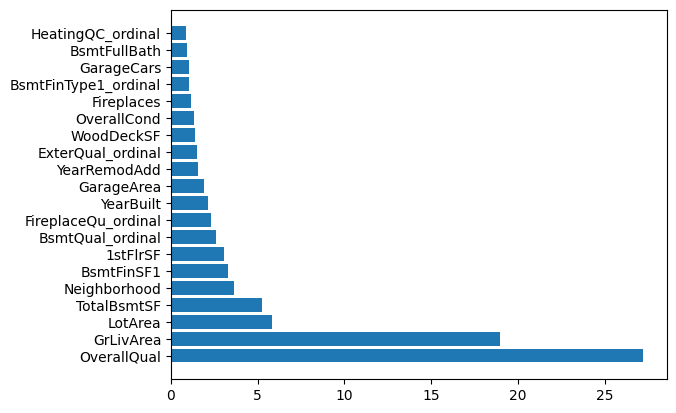

In [34]:
temp = feature_importance_final.iloc[:20,]
plt.barh(temp["feature"], temp["importance_cb_5fk"]);

## Model Evaluation

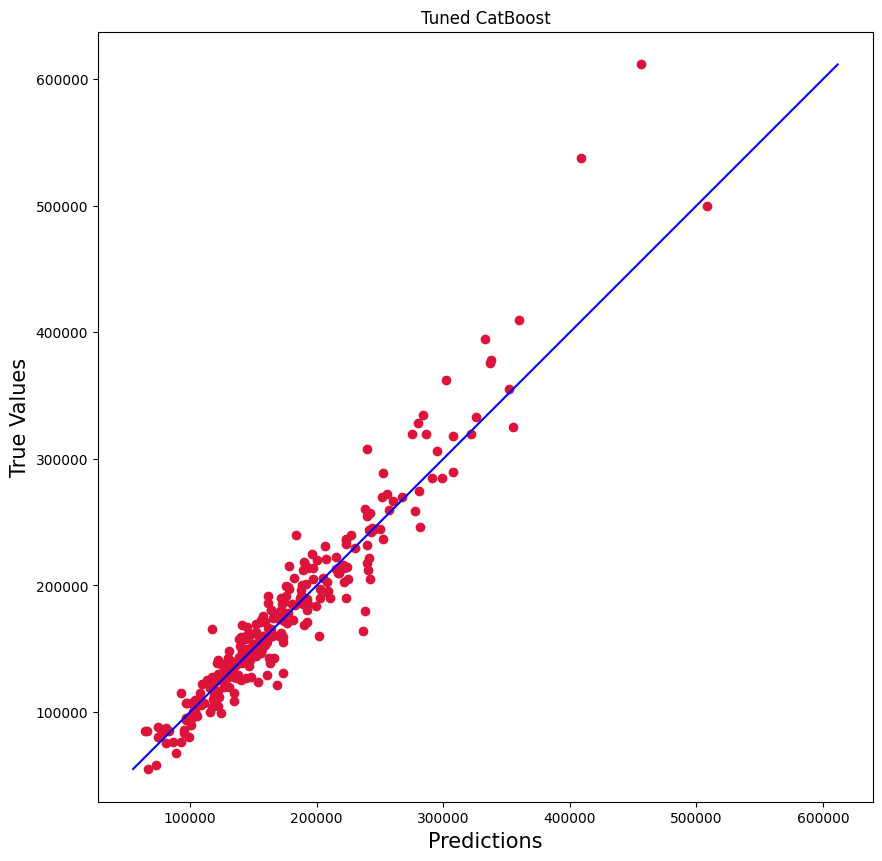

In [35]:
# Plot y_test vs y_test_pred

plt.figure(figsize=(10,10))
plt.scatter(y_test_pred, y_test, c='crimson')

plt.title('Tuned CatBoost')
p1 = max(max(y_test_pred), max(y_test))
p2 = min(min(y_test_pred), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('Predictions', fontsize=15)
plt.ylabel('True Values', fontsize=15)
plt.axis('equal')
plt.show()

### Residual Plot
- After training your final CatBoost model and using it to make predictions on the test set, you can generate a residual plot to visually inspect its performance. This type of plot is a valuable tool for understanding if your model's errors are random or if there are systematic patterns.

- The plot below shows the relationship between your model's predicted values and the residuals (the difference between the actual and predicted values).

- An ideal residual plot will show a random, uniform scatter of points around the horizontal line at y=0. This indicates that your model's errors are random and are not related to the predicted value. It means your model is not systematically over- or under-predicting for certain ranges of house prices.

- In contrast, if you see a discernible pattern in the plot (e.g., a fanning-out shape, a curve, or a clear concentration of points), it suggests that your model may have a bias. For example, a fanning-out pattern could mean that the model's errors increase as the predicted price gets higher, indicating a need for a more complex model or additional features to handle higher-priced homes.

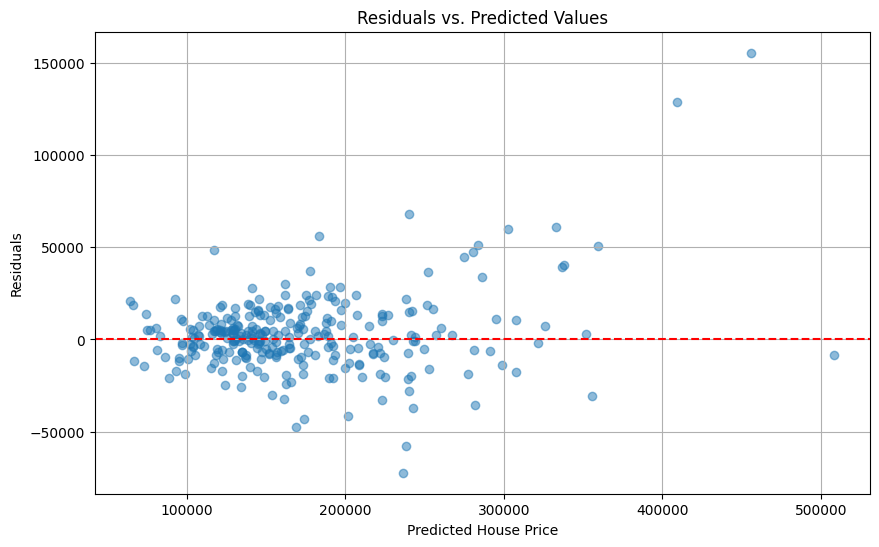

In [36]:
# Plot Residuals vs. Predicted Values

residuals = y_test - y_test_pred

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test_pred, residuals, alpha=0.5)
plt.title('Residuals vs. Predicted Values')
plt.xlabel('Predicted House Price')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.grid(True)
plt.show()
#plt.savefig('residuals_plot.png')

#print("Residuals plot has been generated and saved as 'residuals_plot.png'.")

### Distribution of actual house prices, y_test and y_test_pred
- Overlap: The more the two distributions overlap, the better your model's predictions align with the actual values. An ideal model's y_pred distribution will closely mimic the y_test distribution.

- Shape: The shapes of the two distributions should be similar. If the y_pred distribution is much narrower than the y_test distribution, it means your model is under-predicting the range of prices and is not confident in making predictions for the highest or lowest-priced homes.

- Skewness: If the actual data is skewed (e.g., towards higher prices), your predicted data should show a similar skew.

In [37]:
# Calculate the mean and standard deviation
y_test_mean = np.mean(y_test)
y_test_std = np.std(y_test)
y_test_pred_mean = np.mean(y_test_pred)
y_test_pred_std = np.std(y_test_pred)

print("Actual Values (y_test) statistics:")
print(f"Mean: {y_test_mean:.4f}")
print(f"Standard Deviation: {y_test_std:.4f}")
print("\nPredicted Values (y_test_pred) statistics:")
print(f"Mean: {y_test_pred_mean:.4f}")
print(f"Standard Deviation: {y_test_pred_std:.4f}")

Actual Values (y_test) statistics:
Mean: 174699.6007
Standard Deviation: 74329.6605

Predicted Values (y_test_pred) statistics:
Mean: 171808.3055
Standard Deviation: 65737.7737


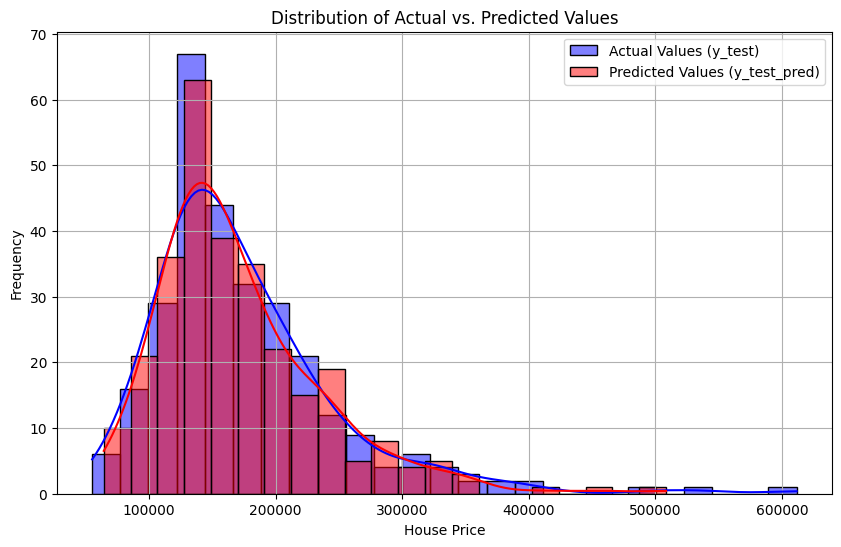

In [38]:
# Plot the distributions of y_test and y_test_pred
plt.figure(figsize=(10, 6))
sns.histplot(y_test, kde=True, color='blue', label='Actual Values (y_test)')
sns.histplot(y_test_pred, kde=True, color='red', label='Predicted Values (y_test_pred)')
#sns.histplot(y, kde=True, color='orange', label='Sales Prices (y)')

plt.title('Distribution of Actual vs. Predicted Values')
plt.xlabel('House Price')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()
#plt.savefig('distribution_plot.png')

#print("Distribution plot has been generated and saved as 'distribution_plot.png'.")

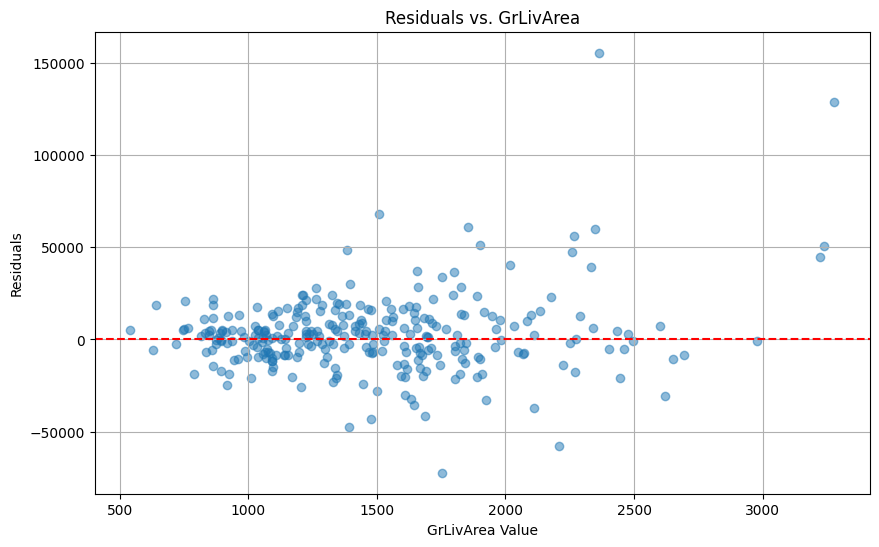

In [39]:
# plot residual vs features

# Choose the feature you want to plot against
feature_to_plot = 'GrLivArea'  # Change this to your desired feature (e.g., 'GrLivArea')
feature_values = X_test[feature_to_plot]

# Create the scatter plot of residuals vs. a chosen feature
plt.figure(figsize=(10, 6))
plt.scatter(feature_values, residuals, alpha=0.5)
plt.title(f'Residuals vs. {feature_to_plot}')
plt.xlabel(f'{feature_to_plot} Value')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.grid(True)
plt.show()
#plt.savefig(f'residuals_vs_{feature_to_plot}.png')

#print(f"Residuals vs. {feature_to_plot} plot has been generated and saved.")

## Model Explainability

### SHAP
- A SHAP value tells you how much a particular feature pushes the model’s predicted house price up or down, compared to the average prediction across the dataset.

In [40]:
# Say the average predicted price is $200,000
# If for House A, the SHAP value for GrLivArea is +15,000, 
# that means the model believes the GrLivArea of House A contributes +$15,000 to the price, 
# compared to the average. If for House B, the SHAP value is -5,000, 
# that means the GrLivArea of House B is lowering the prediction by $5,000 from the average.

In [41]:
import shap

# Fit explainer on train data
explainer = shap.Explainer(final_model)

# Evaluate SHAP values on test set
shap_values = explainer.shap_values(X_test)

#This balances accurate attribution with realistic performance evaluation.

In [42]:
# SHAP feature importance
mean_abs_shap_values = np.abs(shap_values).mean(axis=0)

# Create a DataFrame for easier viewing and sorting
shap_importance = pd.DataFrame({
    'feature': X.columns,
    'mean_abs_shap_cb_5fk': mean_abs_shap_values
})

# Sort in descending order
shap_importance_sorted = shap_importance.sort_values(by='mean_abs_shap_cb_5fk', ascending=False)

# Display
print(shap_importance_sorted.head(30))

# how to interpret:
# # On average, the feature GrLivArea changes the model’s prediction by 15,625 units of currency (likely dollars), 
# either increasing or decreasing the predicted house price.

                 feature  mean_abs_shap_cb_5fk
0              GrLivArea          15686.689725
15           OverallQual           9497.148759
27           TotalBsmtSF           5347.234332
4                LotArea           4896.124782
12          Neighborhood           4599.518233
16           OverallCond           3898.494904
31              1stFlrSF           3723.713747
24            BsmtFinSF1           3707.183809
64   FireplaceQu_ordinal           3666.265975
67   KitchenQual_ordinal           3243.498121
17             YearBuilt           2949.625042
18          YearRemodAdd           2927.804990
71  BsmtFinType1_ordinal           2440.947307
76     HeatingQC_ordinal           2361.831950
46            WoodDeckSF           2094.929139
74     ExterQual_ordinal           2004.289182
41            Fireplaces           1912.815598
68      BsmtQual_ordinal           1675.220384
45            GarageArea           1664.285906
44            GarageCars           1504.831059
34          B

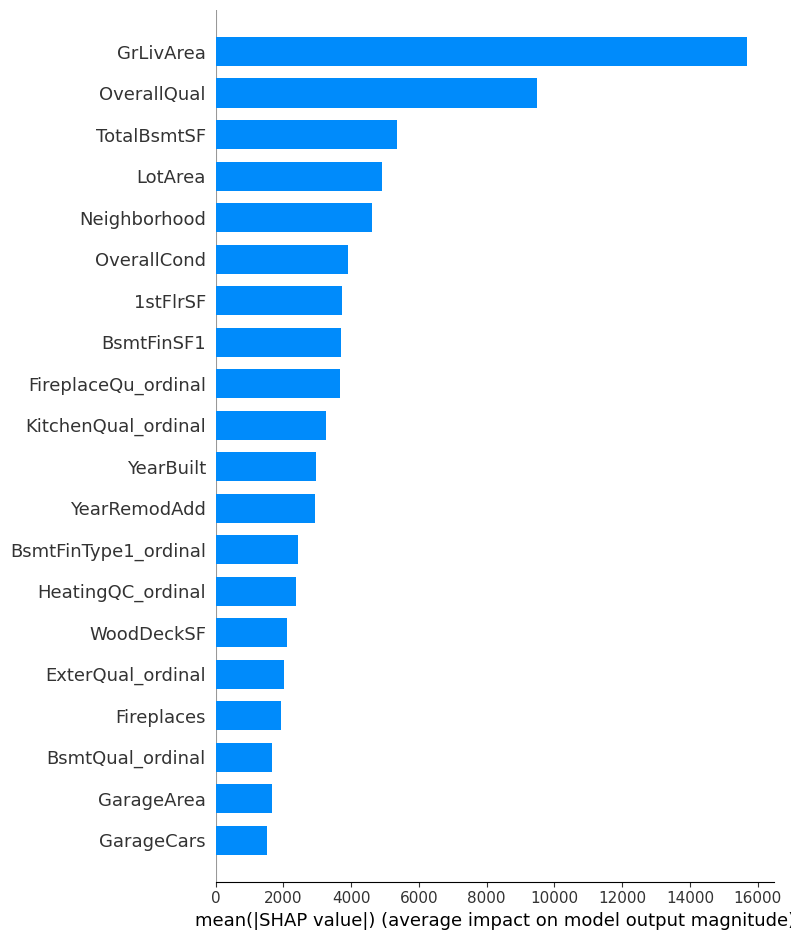

In [43]:
# to visualize the mean abs of SHAP value using summary bar plot
shap.summary_plot(shap_values, X_test, plot_type='bar')

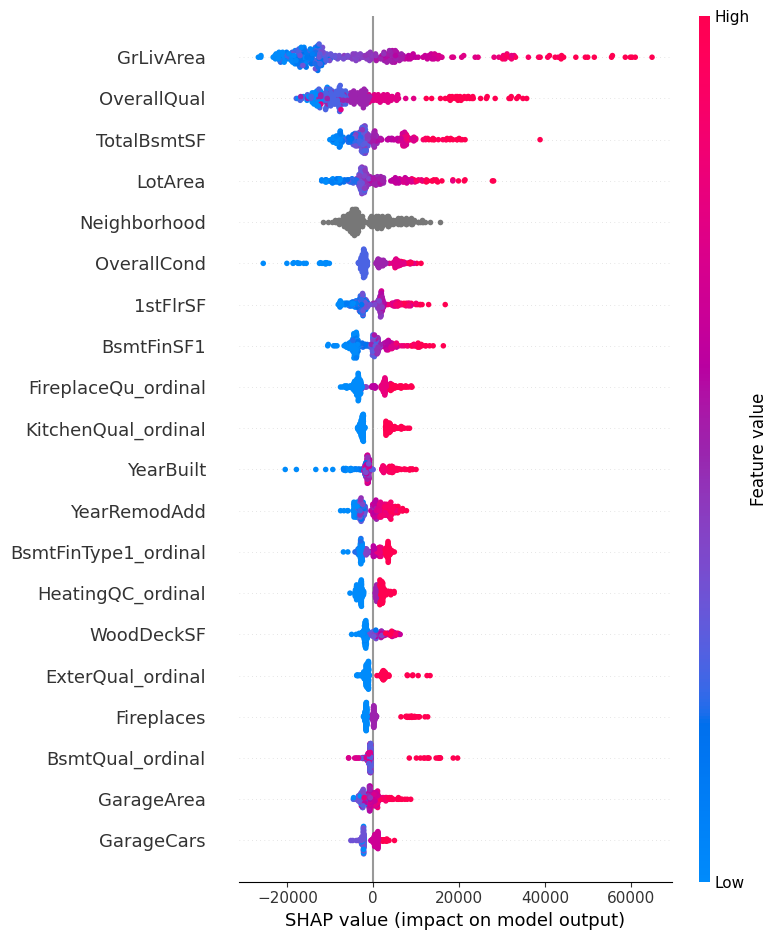

In [44]:
# summary violin plot
shap.summary_plot(shap_values, X_test)

In [45]:
# How to Read the Violin Plot
# ✅ 1. Width of the Violin (Horizontal Spread)

# Wider areas indicate more data points with similar SHAP values.

# This shows the distribution of how much that feature affects predictions across your dataset.

# ✅ 2. Color Gradient (Red → Blue)

# Each dot is colored by the actual value of the feature:

# Red = High feature value

# Blue = Low feature value

# This helps you understand the direction of the effect.

# For example, if red dots are mostly on the right (positive SHAP values), high values of that feature increase the prediction (e.g., higher price).

# If blue dots are on the left (negative SHAP values), low values decrease the prediction.

# ✅ 3. X-Axis (SHAP Value)

# Represents the magnitude and direction of impact on the model’s prediction.

# A value of +5000 means the feature adds $5,000 (for a house price model).

# A value of -3000 means it subtracts $3,000 from the prediction.

### SHAP Dependence Plot
- In a SHAP dependence plot, the x-axis shows the value of the feature you specified, and the y-axis shows the SHAP value (i.e., the feature’s contribution to the model output). But if you’re seeing a second feature encoded on the plot, that’s expected and by design. The second feature (by color) is there to show interactions. The SHAP dependence plot automatically colors the points by the most correlated feature with the one on the x-axis. This helps uncover interactions between features.

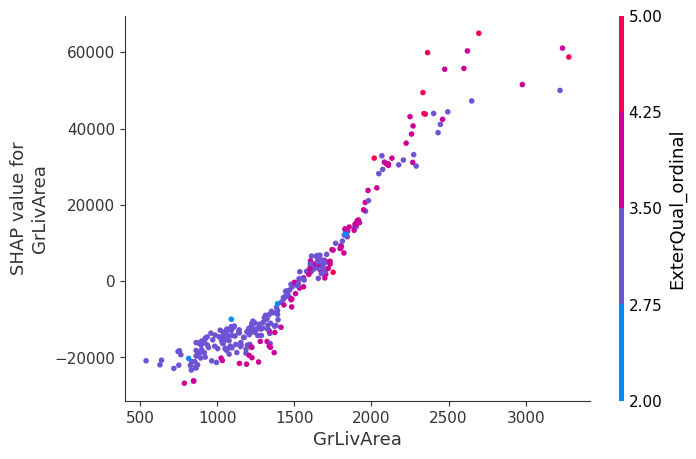

In [46]:
shap.dependence_plot('GrLivArea', shap_values, X_test)

# if don't want to show the second y-axis
#shap.dependence_plot('GrLivArea', shap_values, x_test, interaction_index=None)

<Figure size 600x400 with 0 Axes>

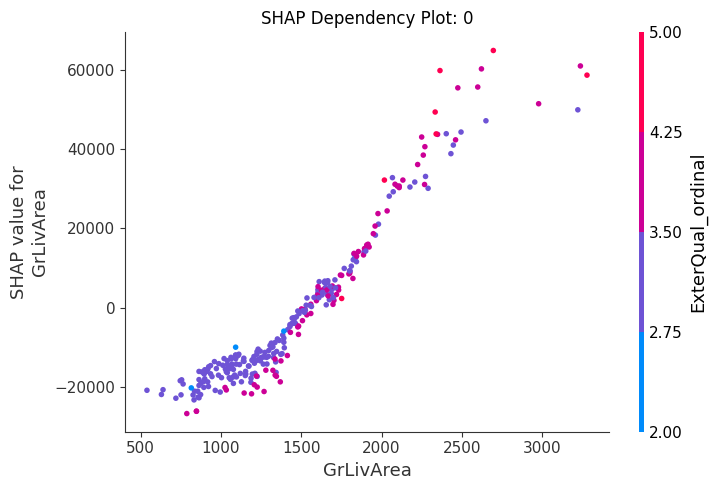

<Figure size 600x400 with 0 Axes>

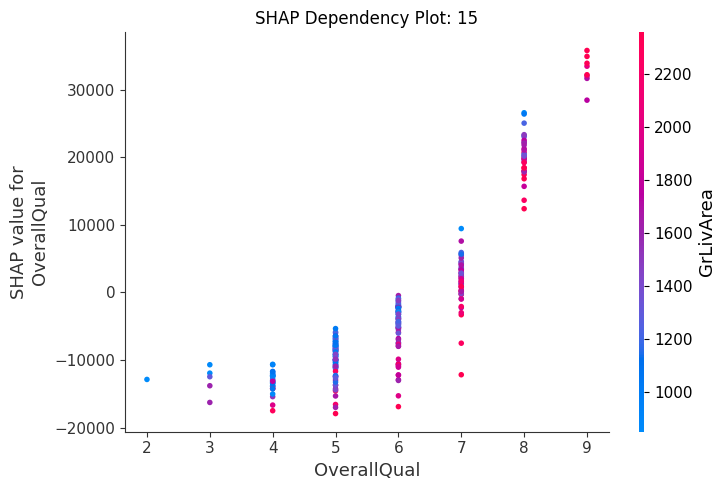

<Figure size 600x400 with 0 Axes>

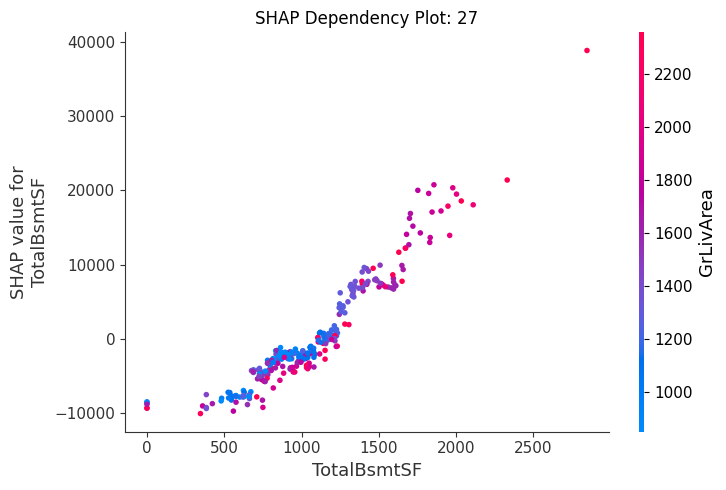

<Figure size 600x400 with 0 Axes>

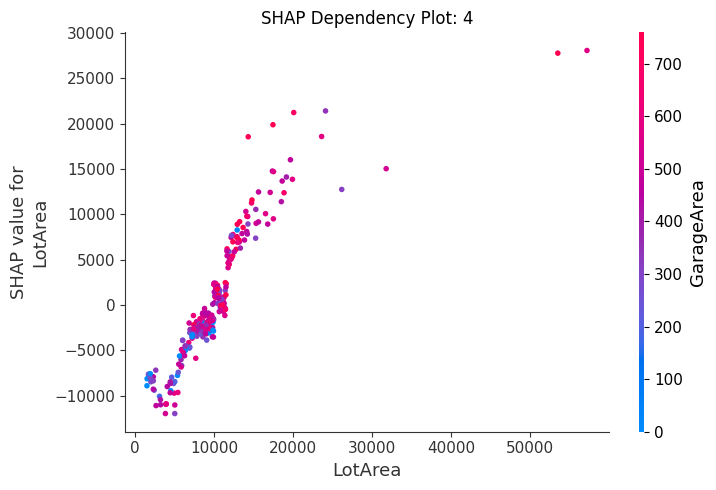

<Figure size 600x400 with 0 Axes>

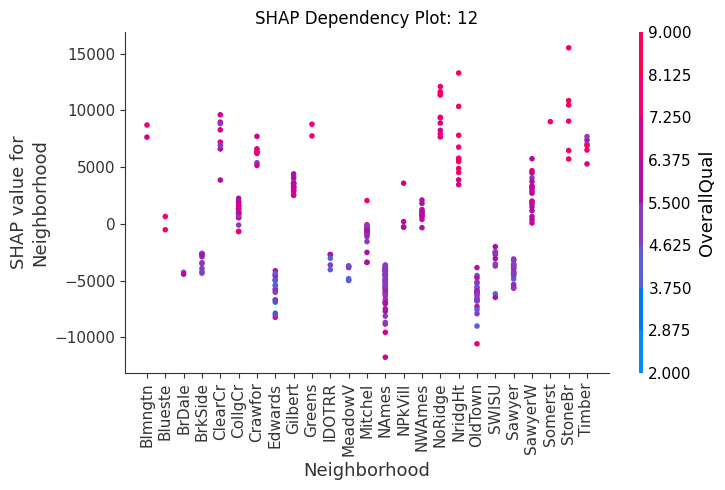

<Figure size 600x400 with 0 Axes>

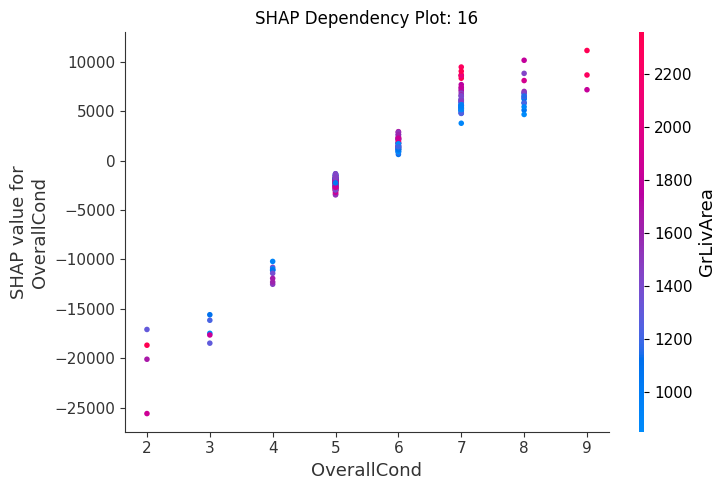

<Figure size 600x400 with 0 Axes>

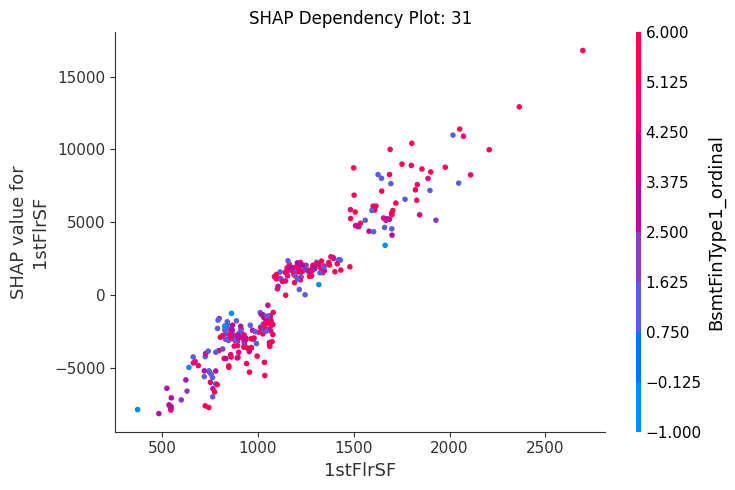

<Figure size 600x400 with 0 Axes>

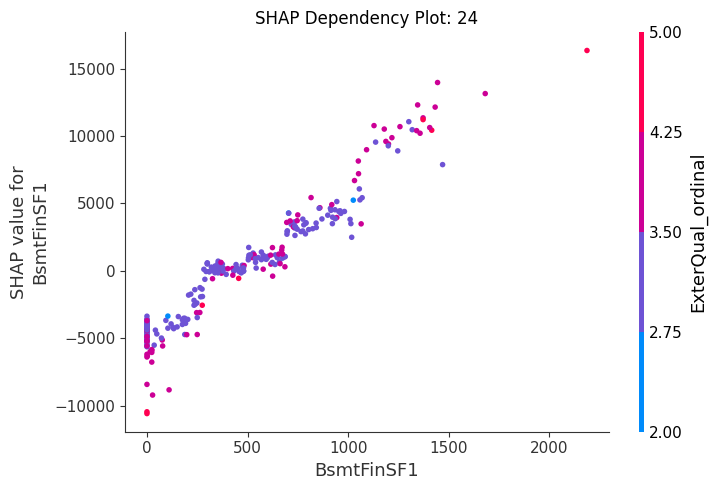

<Figure size 600x400 with 0 Axes>

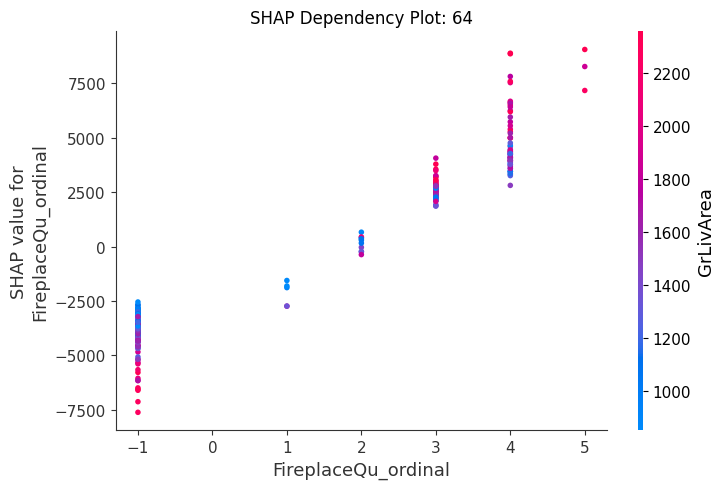

<Figure size 600x400 with 0 Axes>

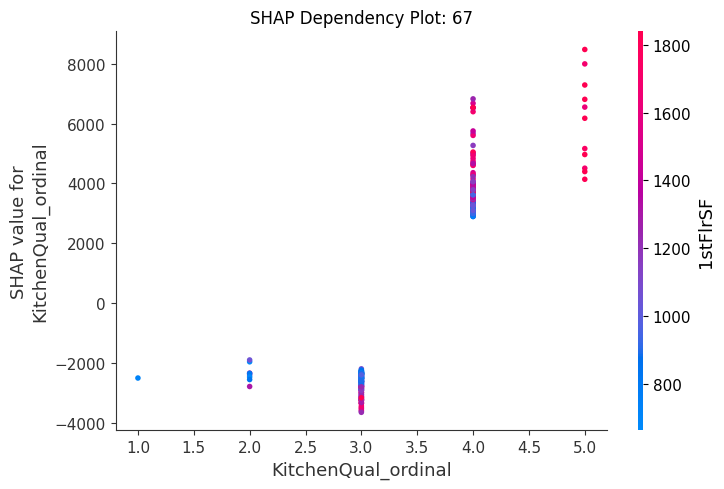

<Figure size 600x400 with 0 Axes>

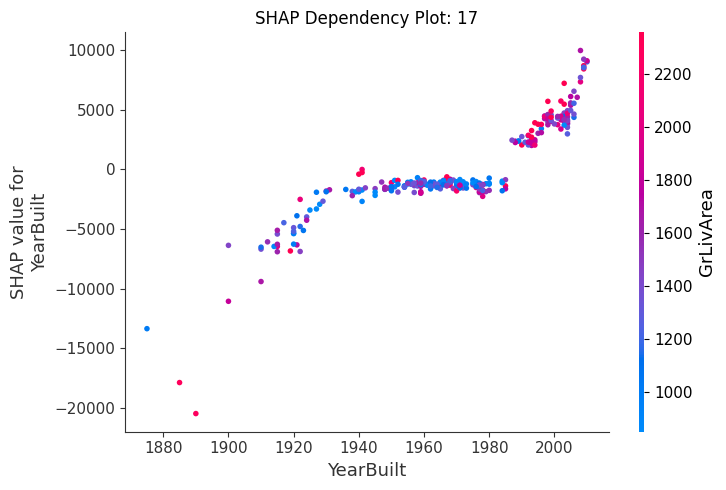

<Figure size 600x400 with 0 Axes>

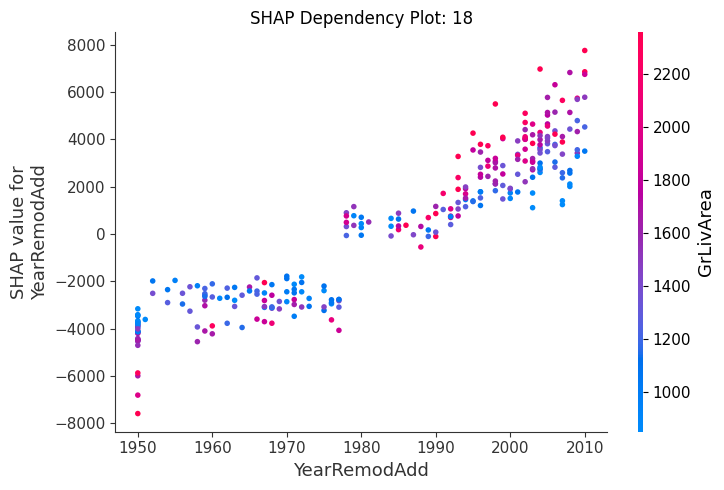

<Figure size 600x400 with 0 Axes>

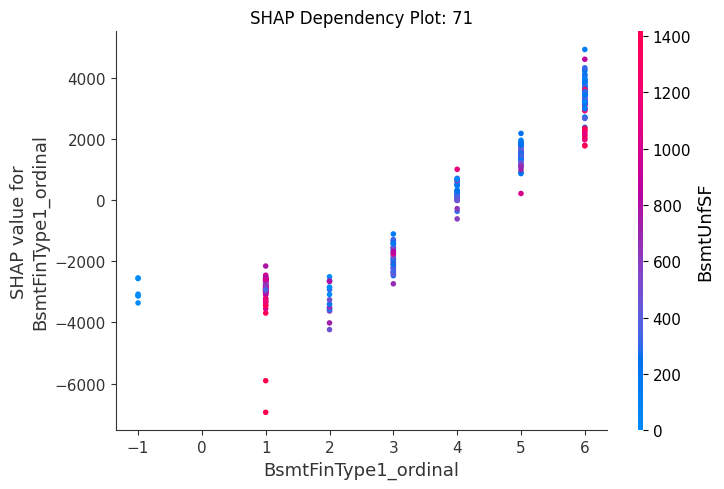

<Figure size 600x400 with 0 Axes>

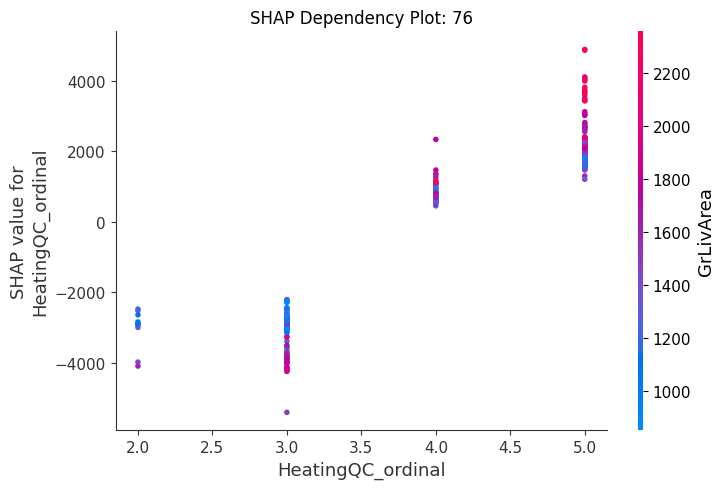

<Figure size 600x400 with 0 Axes>

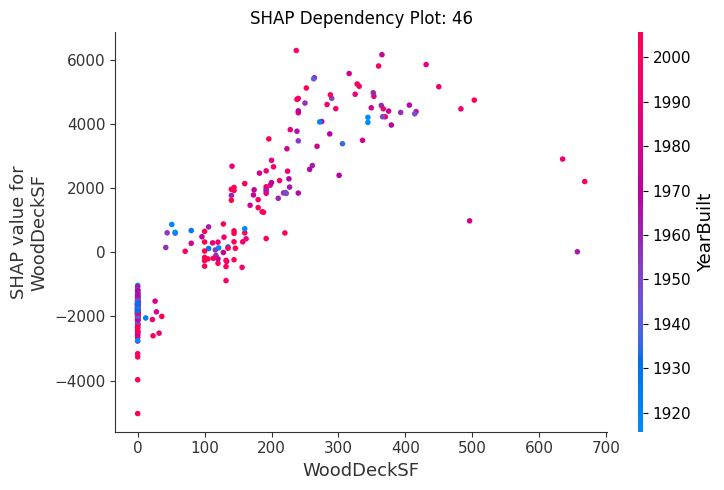

<Figure size 600x400 with 0 Axes>

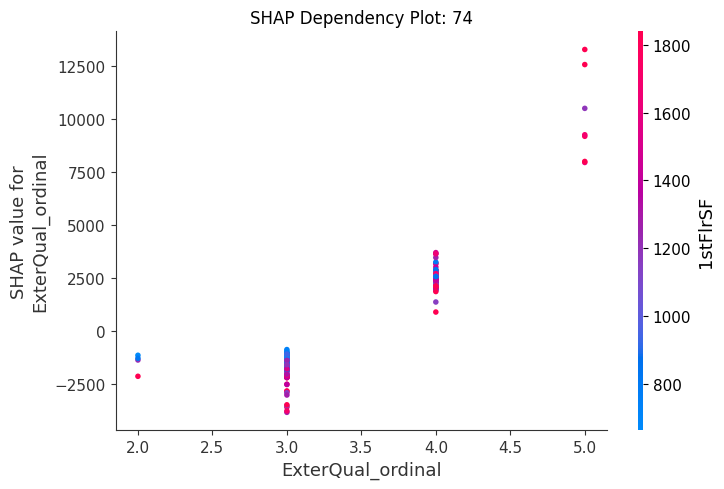

<Figure size 600x400 with 0 Axes>

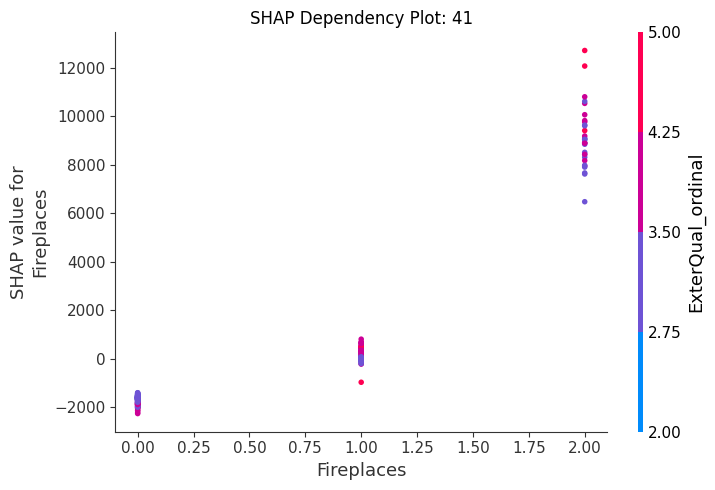

<Figure size 600x400 with 0 Axes>

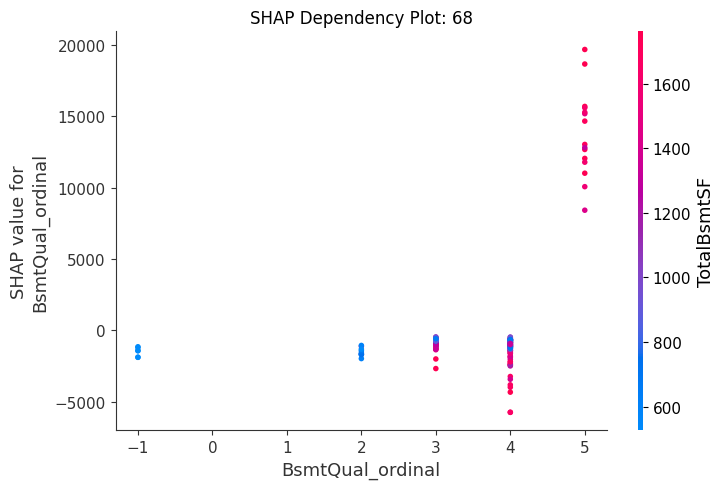

<Figure size 600x400 with 0 Axes>

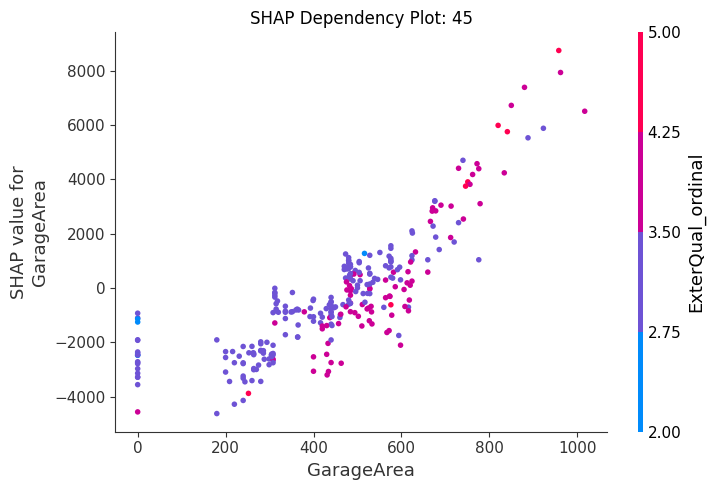

<Figure size 600x400 with 0 Axes>

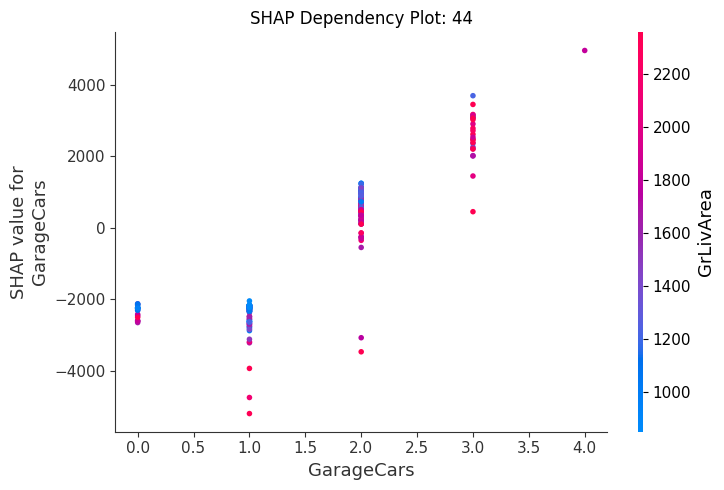

In [47]:
# Select top 20 features
top_features = shap_importance_sorted.head(20).index.tolist()

for feature in top_features:
    plt.figure(figsize=(6, 4))  # Compact size
    
    shap.dependence_plot(
        feature,
        shap_values,
        X_test,
        #interaction_index=None,  # Auto-picks a good feature for color encoding
        show=False
    )
    plt.title(f"SHAP Dependency Plot: {feature}")
    plt.tight_layout()
    plt.show()
    
    # Save plot to file
#     filename = f"shap_dependency_{feature}.png"
#     plt.savefig(filename, dpi=150)
#     plt.close()

# how to interpret
# using OverallQual as an example,
# 1stFlrSF is the most correlated feature with Overall
# you can see larger homes with high OverallQual have even higher SHAP values (strong positive synergy).
# Conversely, small homes (blue dots) with high OverallQual may still not be valued as highly.

In [48]:
 # 3. SHAP Force Plots (Local Explainability)
print("\n" + "="*50)
print("Generating SHAP Force Plots...")
print("="*50)

# The force plot explains a single prediction. Let's pick the first instance from the test set.
# It shows which features push the prediction higher (red) or lower (blue) than the baseline.
# The baseline value is the average of the model's predictions over the entire dataset.
sample_index = 1

# For a single observation
print(f"\nGenerating force plot for a single instance (index: {sample_index})...")
# `shap.initjs()` is needed for the JavaScript plot to render correctly in notebooks.
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[sample_index, :], X_test.iloc[sample_index, :])

# For the entire dataset (or a large number of samples), a global force plot can be generated.
# This gives an overview of how features affect the predictions across many instances.
#print("\nGenerating force plot for the entire dataset...")
#shap.force_plot(explainer.expected_value, shap_values, X_test)


Generating SHAP Force Plots...

Generating force plot for a single instance (index: 1)...


### Export lists for final model comparison

In [49]:
shap_importance_sorted

feature  mean_abs_shap_cb_5fk
0            GrLivArea          15686.689725
15         OverallQual           9497.148759
27         TotalBsmtSF           5347.234332
4              LotArea           4896.124782
12        Neighborhood           4599.518233
..                 ...                   ...
20            RoofMatl             17.670658
61  GarageQual_ordinal             16.424645
53         MiscFeature             12.680155
51            PoolArea             10.642558
9            Utilities              0.678866

[80 rows x 2 columns]

In [50]:
# export SHAP importance data into a csv
shap_importance_sorted.reset_index(inplace=True)
shap_importance_sorted.to_csv('shap_importance_cb.csv', index=False)

In [51]:
# Create a new DataFrame that includes the best value from the tuning process as well.
# This addresses the user's specific request.
full_comparison = pd.DataFrame({
    'model': ['CatBoost'] * 3,
    'metric': ['Test_R2', 'Best_Tuned_R2', 'Final_CV_mean_R2'],
    'score': [r2_5kf_test, study.best_value, cv_r2_mean]
})

In [52]:
full_comparison

model            metric     score
0  CatBoost           Test_R2  0.915860
1  CatBoost     Best_Tuned_R2  0.945146
2  CatBoost  Final_CV_mean_R2  0.930022

In [53]:
# export R2 scores into a csv
full_comparison.reset_index(inplace=True)
full_comparison.to_csv('r2_cb.csv', index=False)